## COVID-19 Segmentation


In [1]:
# import packages
import os
import gc
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# image preprocessing
import nibabel as nib
from PIL import ImageOps
from skimage import exposure
from IPython.display import Image, display


# deep learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import load_img

print(f'Tensorflow Version: {tf.__version__}')
print(f'Keras Version: {tf.keras.__version__}')

Tensorflow Version: 2.3.0
Keras Version: 2.4.0


## Load Data

In [2]:
# directories
DF = '../data/metadata.csv'

# read dataframe
meta = pd.read_csv(DF)
meta = meta.replace('../input/covid19-ct-scans/', '../data/', regex=True)
meta.head(4)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../data/ct_scans/coronacases_org_001.nii,../data/lung_mask/coronacases_001.nii,../data/infection_mask/coronacases_001.nii,../data/lung_and_infection_mask/coronacases_00...
1,../data/ct_scans/coronacases_org_002.nii,../data/lung_mask/coronacases_002.nii,../data/infection_mask/coronacases_002.nii,../data/lung_and_infection_mask/coronacases_00...
2,../data/ct_scans/coronacases_org_003.nii,../data/lung_mask/coronacases_003.nii,../data/infection_mask/coronacases_003.nii,../data/lung_and_infection_mask/coronacases_00...
3,../data/ct_scans/coronacases_org_004.nii,../data/lung_mask/coronacases_004.nii,../data/infection_mask/coronacases_004.nii,../data/lung_and_infection_mask/coronacases_00...


## Utility Function

In [3]:
# Loading nii files
def readNIB(image, size=224):
    
    '''
    Read .nii Image
    -----------------------
    Load .nii images using
    nibabel and resize them.
    
    Arguments:
    image -- Input .nii file (CT) images.
    
    Returns:
    data - numpy array of dtype float64.
    '''
    
    data = []
    
    ct_image = nib.load(image).get_fdata()
    ct_90 = np.rot90(ct_image)
    slices = ct_90.shape[2]
    array = ct_90[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    
    for img_no in range(0, array.shape[0]):
        img = cv2.resize(array[img_no], dsize=(size, size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)
        data.append(img)
        
    return np.array(data)

# Contrast Limited Adaptive Histogram Equilization
def Enhancer(image, demo=0):
    
    '''
    Enhance Image.
    ------------------
    Using CLAHE to enhance contrast.
    
    Arguments:
    image -- Input CT image.
    
    Return:
    image -- CLAHE Image.
    '''
    ori_flatten = image.flatten()
    
    image = exposure.equalize_adapthist(image)
    image *= 255
    image = np.uint8(image)
    
    clahe_flatten = image.flatten()

    if demo == 1:
        
        fig = plt.figure()
        plt.rcParams['figure.figsize'] = 10, 10
        
        plt.subplot(2, 2, 1)
        plt.imshow(image, cmap='bone')
        plt.title('CT-Scan')
        
        plt.subplot(2, 2, 2)
        plt.hist(ori_flatten)
        plt.title("Histogram of CT-Scan")

        plt.subplot(2, 2, 3)
        plt.imshow(image, cmap='bone')
        plt.title("CLAHE Enhanced CT-Scan")

        plt.subplot(2, 2, 4)
        plt.hist(clahe_flatten)
        plt.title("Histogram of CLAHE Enhanced CT-Scan")
        
    return image

# Crop images 

def Cropper(test_img):
    
    '''
    Crop Image
    ----------------------
    Crop image on the basis of
    lung mask contours and use those 
    contours to crop CT scan and 
    infection masks.
    
    Arguments:
    test_img -- Input image.
    
    Returns:
    points_lung1 -- co-ordinates of 1st lung contour. 
    points_lung2 -- co-ordinates of 2nd lung contour.
    '''
    
    test_img = test_img*255
    test_img = np.uint8(test_img)

    contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]

    x = np.argsort(areas)

    max_index = x[x.size - 1]
    cnt1=contours[max_index]
    second_max_index = x[x.size - 2]
    cnt2 = contours[second_max_index]
    x,y,w,h = cv2.boundingRect(cnt1)
    p,q,r,s = cv2.boundingRect(cnt2)

    cropped1 = test_img[y:y+h, x:x+w]
    cropped1 = cv2.resize(cropped1, dsize=(112,224), interpolation=cv2.INTER_AREA)
    cropped2 = test_img[q:q+s, p:p+r]
    cropped2 = cv2.resize(cropped2, dsize=(112,224), interpolation=cv2.INTER_AREA)

    points_lung1 = []
    points_lung2 = []

    points_lung1.append(x); points_lung1.append(y); points_lung1.append(w); points_lung1.append(h)
    points_lung2.append(p); points_lung2.append(q); points_lung2.append(r); points_lung2.append(s)

    return(points_lung1, points_lung2)

# Prepare Image Data
def prepareData(num=5):
    
    '''
    Prepare Image data.
    ------------------------------------------
    Remove noise and reshape them (B, W, H, C).
    Crop images on the basis of lung contours. 
    Apply CLAHE enhancer and resize images.
    
    Arguments:
    num -- number of observation in .csv file.
     
    Returns:
    cts -- list of ct scans.
    infection -- list of corresponding infection mask.
    '''
    
    cts = []
    infections = []
    
    for i in range(num):
    
        lung_img = readNIB(meta.loc[i, 'lung_mask'])
        ct_img = readNIB(meta.loc[i, 'ct_scan'])
        infection_img = readNIB(meta.loc[i, 'infection_mask'])

        for num in range(0, lung_img.shape[0]):     
            lung = lung_img[num]
            ct = ct_img[num]
            infection = infection_img[num]

            ct = Enhancer(ct)
            
            points1, points2 = Cropper(lung)
            
            a,b,c,d = points1
            e,f,g,h = points2
            img1 = ct[b:b+d, a:a+c]
            img1 = cv2.resize(img1, dsize=(112, 224), interpolation=cv2.INTER_AREA)
            img2 = ct[f:f+h, e:e+g]
            img2 = cv2.resize(img2, dsize=(112, 224), interpolation=cv2.INTER_AREA)
            ct = np.concatenate((img1, img2), axis=1)
            
            infec = np.uint8(infection*255)
            img3 = infec[b:b+d, a:a+c]
            img3 = cv2.resize(img3, dsize=(112,224), interpolation=cv2.INTER_AREA)
            img4 = infec[f:f+h, e:e+g]
            img4 = cv2.resize(img4, dsize=(112,224), interpolation=cv2.INTER_AREA)
            infection = np.concatenate((img3, img4), axis=1)
            
            cts.append(ct)
            infections.append(infection)
            
    return cts, infections

## Testing

Testing functions and image preprocessing.

In [4]:
test_image = meta.loc[0, 'ct_scan']
image = readNIB(test_image)
print(image.shape)
print(image.dtype)

(181, 224, 224)
float64


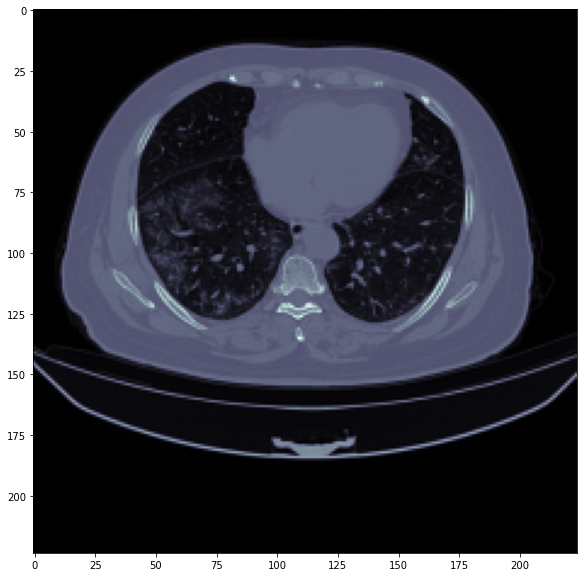

In [5]:
plt.rcParams['figure.figsize'] = 10, 10
plt.imshow(image[60], cmap='bone')

## Contrast Enhancement: CLAHE

We are going to enhance contrast using Contrast Limited Adaptive Histogram Equilization to enhance CT-Scan Images.

In [6]:
CLAHE = exposure.equalize_adapthist(image[60], clip_limit=0.02)
print(CLAHE.shape)
print(CLAHE.dtype)

(224, 224)
float64


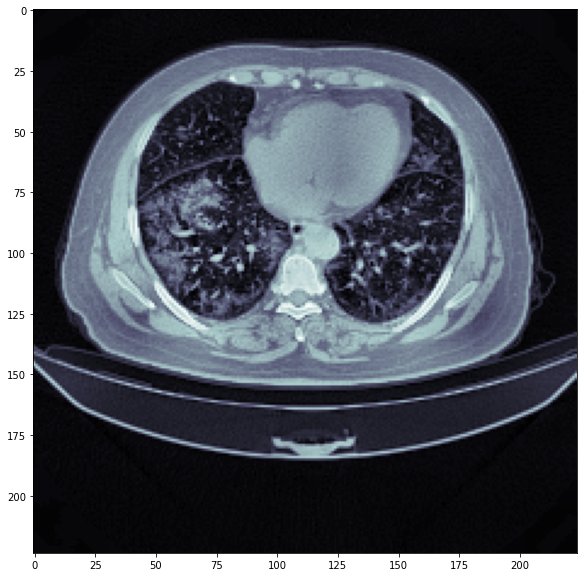

In [7]:
plt.rcParams['figure.figsize'] = 10, 10
plt.imshow(np.uint8(CLAHE*255), cmap='bone')

We are going to write function in order to apply Contrast Limited Adaptibe Histogram Enhancement (CLAHE) on ct scan images. This images are of float64 dtype. We first need to apply CLAHE using scikit image's exposure module and than we will change the image dtype to uint8 for further preprocessing and work. 

In [8]:
# Function for CLAHE
def Enhancer(image):
    
    image = exposure.equalize_adapthist(image)
    image *= 255
    image = np.uint8(image)
    return image

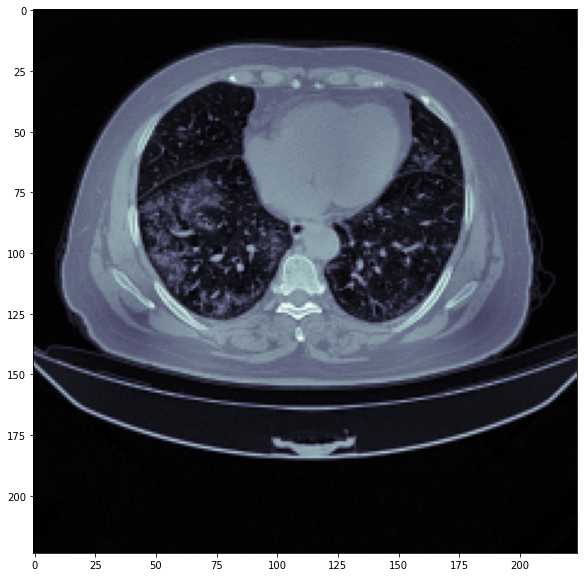

In [10]:
img = Enhancer(image[60])
plt.imshow(img, cmap='bone')

In [10]:
img.dtype

dtype('uint8')

In [11]:
cts , infec = prepareData()

C:\Users\kscho\miniconda3\envs\tf2.3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [12]:
gc.collect()

70

In [13]:
print(len(cts))
print(len(infec))
print(infec[60].dtype)
print(cts[60].dtype)

757
757
uint8
uint8


(224, 224) (224, 224)


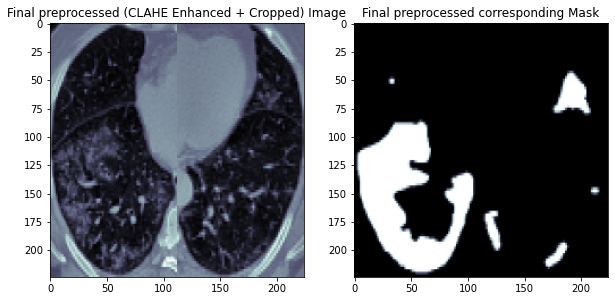

In [14]:
x = 60
plt.rcParams['figure.figsize'] = 10,10

plt.subplot(1, 2, 1)
plt.imshow(cts[x], cmap='bone')
plt.title("Final preprocessed (CLAHE Enhanced + Cropped) Image")

plt.subplot(1, 2, 2)
plt.imshow(infec[x], cmap='bone')
plt.title("Final preprocessed corresponding Mask")

print(cts[x].shape, infec[x].shape)

# Filtering Infection Mask

There are some infection mask after processing which are totally empty which means they are all black image. We need to remove these empty infection mask and also corresponding ct images.

In [15]:
no_masks = []
for i in range(0, len(infec)):
    if np.unique(infec[i]).size == 1:
        no_masks.append(i)
        
print("Number of complete black masks :" , len(no_masks))

for index in sorted(no_masks, reverse = True):  
    del infec[index]  
    del cts[index]

Number of complete black masks : 131


In [16]:
print(len(cts))
print(len(infec))
print(cts[x].dtype)
print(infec[x].dtype)

626
626
uint8
uint8


In [17]:
def plot_sample(array_list, color_map = 'nipy_spectral', new_dim=224):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(10,30))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')

    # plt.subplot(1,2,2)
    # plt.imshow(array_list[0], cmap='bone')
    # plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    # plt.title('Lung Mask')

    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    plt.show()

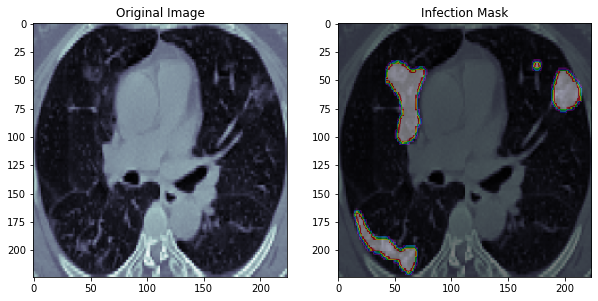

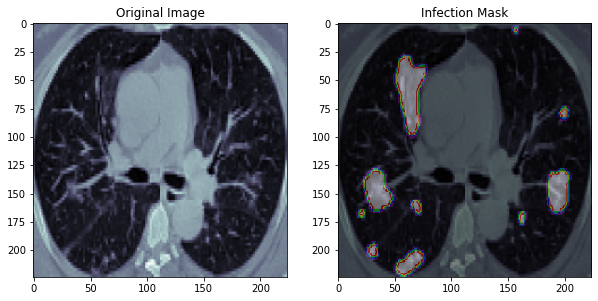

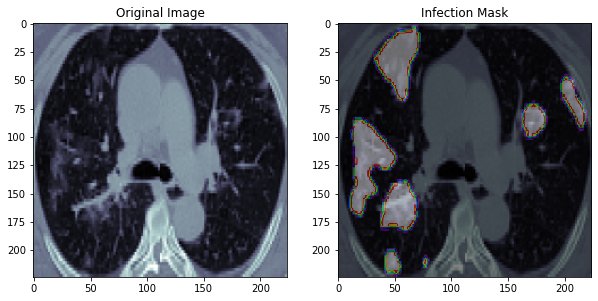

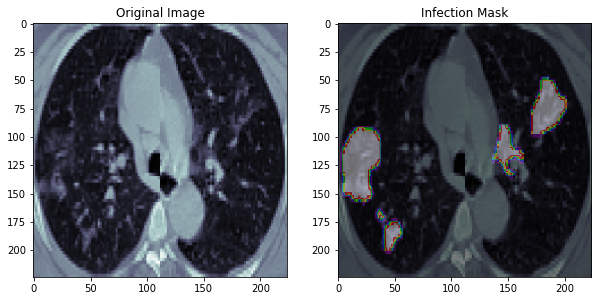

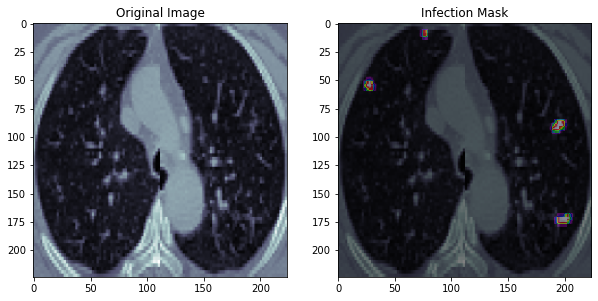

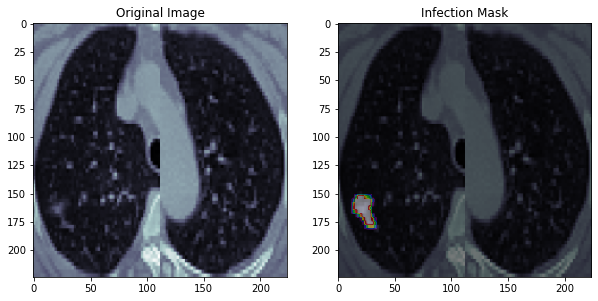

In [18]:
for index in [100,110,120,130,140,150]:
    plot_sample([cts[index], infec[index]])

## Train-Test Split

In [19]:
dim=224
cts = np.array(cts)
infec = np.array(infec)
cts = cts.reshape(len(cts), dim, dim, 1)
infections = infec.reshape(len(infec), dim, dim, 1)

In [20]:
x_train, x_valid, y_train, y_valid = train_test_split(cts, infec, test_size=0.3, random_state=42)

In [21]:
print(x_train.shape, x_valid.shape)

(195, 224, 224, 1) (84, 224, 224, 1)


## Metric